In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!pwd
%cd /content/drive/My Drive/
!pwd
!ls

## Importing packages

In [0]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import keras.backend as K
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
%matplotlib inline
tf.keras.backend.clear_session()

## Loading data

In [0]:
def load_data(input_shape):
    input_dim = input_shape
    train_labels = pd.read_csv("train_labels.csv")
    test_labels = pd.read_csv("test_labels.csv")
    x_train, y_train, x_test, y_test = [], [], [], []
    # max = 244 and min = 128
    #x_center = xmin + 7
    previous_name = ""
    y_temp = np.zeros((1, 1))

    for index, row in train_labels.iterrows():
        current_name = row["filename"]
        x_center, y_center = (row["xmin"] + 7)/row["width"], (row["ymin"] + 7)/row["height"]
        x_center, y_center =  int(input_dim[0]* x_center),  int(input_dim[0]* y_center)
        sys.stdout.write('\r'+'idx_train=' + str(index))
        if current_name is not previous_name:
        
            if y_temp.shape[0] == input_dim[0]:
                y_train.append(y_temp)
            y_temp = np.zeros(input_dim)    
            img =cv2.resize(cv2.imread("train/"+current_name, 0),input_dim[:2])
            img = np.expand_dims(img, axis = -1)
            x_train.append(img)
            previous_name = current_name
        
        y_temp[y_center - 3: y_center +3 , x_center - 3: x_center +3, :] = 1
    y_train.append(y_temp)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    previous_name = ""
    y_temp = np.zeros((1, 1))

    for index, row in test_labels.iterrows():
        current_name = row["filename"]
        x_center, y_center = (row["xmin"] + 7)/row["width"], (row["ymin"] + 7)/row["height"]
        x_center, y_center =  int(input_dim[0]* x_center),  int(input_dim[0]* y_center)
        sys.stdout.write('\r'+'idx_test=' + str(index))
        if current_name is not previous_name:
        
            if y_temp.shape[0] == input_dim[0]:
                y_test.append(y_temp)
            y_temp = np.zeros(input_dim)    
            img =  cv2.resize(cv2.imread("test/"+current_name, 0), input_dim[:2])
            img = np.expand_dims(img, axis = -1)
            x_test.append(img)
            previous_name = current_name
        
        y_temp[y_center - 3: y_center +3 , x_center - 3: x_center +3, :] = 1
    y_test.append(y_temp)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    assert(x_train.shape == (1653, input_dim[0],input_dim[1], input_dim[2]))
    assert(x_test.shape == (183, input_dim[0],input_dim[1], input_dim[2] ))
    assert(y_train.shape == (1653, input_dim[0],input_dim[1], input_dim[2] ))
    assert(y_test.shape == (183, input_dim[0],input_dim[1], input_dim[2] ))
    print("\nx_train shape: ", x_train.shape)
    print("y_train shape: ", y_train.shape)
    print("x_test shape: ", x_test.shape)
    print("y_test shape: ", y_test.shape)

    return x_train, y_train, x_test, y_test




In [ ]:
x_train, y_train, x_test, y_test = load_data(input_shape = (256, 256, 1))

## finding Best parameters for Canny edge detector

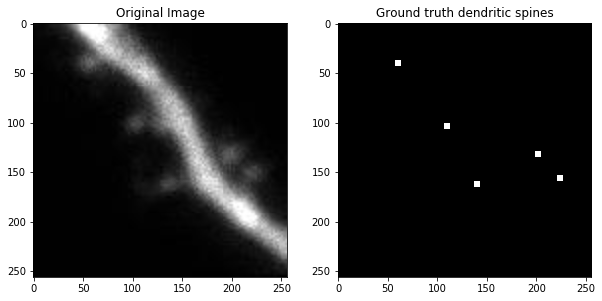

In [0]:
img = x_train[2, :, :,0]
label_train = y_train[2 , :, :, 0]
img_filtered =cv2.bilateralFilter(img, 11, 150, 150)
threshholds = list(range(0, 251, 5))

plt.figure(figsize= (10, 20))
plt.subplot(121)
plt.imshow(img,cmap = 'gray')
plt.title('Original Image')
plt.subplot(122)
imgplot2 = plt.imshow(label_train, cmap='gray')
plt.title('Ground truth dendritic spines')
plt.show()

edges_2 = cv2.Canny(img_filtered, 10, 25, L2gradient = True)
row = 0
col = 0
s = 1
title = ""
i = 0
while i < len(threshholds) - 1:
    j = i + 1
    while j < len(threshholds):
        if col == 0 and row != 3:
            edges_1 = cv2.Canny(img_filtered,threshholds[i] ,threshholds[j], L2gradient = True)
            col = col + 1
            title = title + " | " + str(threshholds[i]) + " " + str(threshholds[j])
            j = j + 1
            continue
        
        elif col < 5 and row != 3:
            edges_row = cv2.hconcat((edges_1, cv2.Canny(img_filtered,threshholds[i] ,threshholds[j], L2gradient = True)))
            edges_1 = edges_row
            col = col + 1
            title = title + " | " + str(threshholds[i]) + " " + str(threshholds[j])
            j = j + 1
            continue
        col = 0
        if row ==0:
            edges_row1 = edges_row
            edges_1 = cv2.Canny(img_filtered,threshholds[i] ,threshholds[j], L2gradient = True)
            col = col + 1
            row = row + 1
            title = title + " | " + str(threshholds[i]) + " " + str(threshholds[j])
            j = j + 1
            continue
        elif row < 3:
            result = cv2.vconcat((edges_row1, edges_row))
            edges_row1 = result
            row = row + 1
            continue
        col = 0
        row = 0 
        cv2.namedWindow(str(s) + " from 85 "+title)        
        cv2.moveWindow(str(s) + " from 85 "+title, 10,10)
        cv2.imshow(str(s) + " from 85 "+title,result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        s = s +1
        title = ""
    i = i + 1
if title != "":
    cv2.namedWindow(str(s) + " from 85 "+title)        
    cv2.moveWindow(str(s) + " from 85 "+title, 35,20)
    cv2.imshow(str(s) + " from 85 "+title,cv2.vconcat((edges_row1, edges_row)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Creating edges dataset using min and max thresholds = (15, 30)

In [0]:
def generate_edges_dataset(x_train, minthresh = 15, maxthresh = 30):
    
    x_train_edges = []
    for i in range(x_train.shape[0]):
        img = x_train[i, :, :, 0]
        img_filtered = cv2.bilateralFilter(img, 11, 150, 150)
        img_edges = cv2.Canny(img_filtered, minthresh, maxthresh, L2gradient = True)
        img_edges = np.expand_dims(img_edges, axis = -1)
        x_train_edges.append(img_edges)
    x_train_edges = np.array(x_train_edges)
    assert(x_train_edges.shape == x_train.shape)
    print("x_train_edges shape: ", x_train_edges.shape)
    
    return x_train_edges

In [0]:
x_train_edges = generate_edges_dataset(x_train)

x_train_edges shape:  (1653, 256, 256, 1)


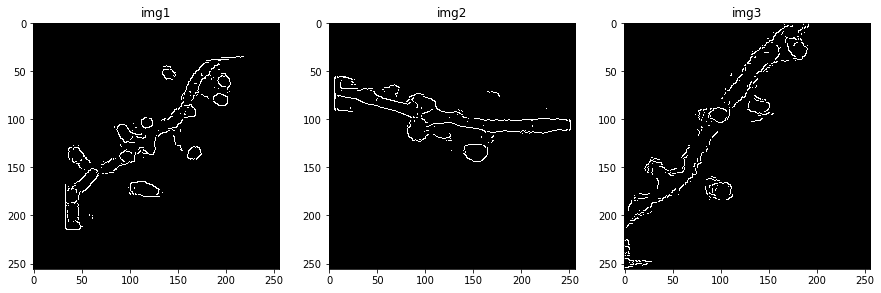

In [0]:
img1 = x_train_edges[15, :, :,0]
img2 = x_train_edges[16, :, :,0]
img3 = x_train_edges[17, :, :,0]
plt.figure(figsize= (15, 80))

plt.subplot(131)
plt.imshow(img1,cmap = 'gray')
plt.title('img1')

plt.subplot(132)
plt.imshow(img2,cmap = 'gray')
plt.title('img2')

plt.subplot(133)
plt.imshow(img3,cmap = 'gray')
plt.title('img3')

plt.show()

## Loading shapes

In [0]:
def load_shapes(input_dim, verbose = 0):
    input_dim = input_dim
    shapes = []
    for i in range(1, 11):
        img = "shape"+str(i)+".JPG"
        image = cv2.resize(cv2.imread(img, 0), (19, 19))
        if verbose is 1:
            plt.figure()
            plt.subplot(121)
            plt.imshow(image,cmap = 'gray')
        ret,img_thresh = cv2.threshold(image,35,255,cv2.THRESH_BINARY)        
        if verbose is 1:
            plt.subplot(122)
            plt.imshow(img_thresh,cmap = 'gray')
            plt.show() 
        img_thresh = np.expand_dims(img_thresh, -1)
        shapes.append(img_thresh)
    shapes = np.array(shapes)
    print("shape_priors shape :",shapes.shape)

In [ ]:
shape_priors = load_shapes((19, 19, 1))

## Building the CNN model 

In [0]:
img_inputs = keras.Input(shape=(256, 256, 1))
x = layers.Conv2D(64, (5, 5),padding = 'same', activation='relu')(img_inputs)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation='relu')(x)
y_hat = layers.Conv2D(1, (3, 3),padding = 'same')(x)

model = keras.Model(inputs=img_inputs, outputs=y_hat)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
conv

## Defining the shape_prior custom loss function

In [0]:
def prior_info_loss(x_hat, y, y_hat, alpha, S_shapes):
    # TODO: implement the regulizer
    # use the edges and S as global variable. find the final sum SUM and substract it from the the below loss
    # to find sum apply on y_pred: threshold, windowmax, guassian filter
        #1 - Y_hat need to be threshholde 0.2 and then max_pooled with g() fct with stide 1 and padding 'same'
    def g_p(y_hat):
      #K.layers.MaxPooling2D(pool_size=(2, 2), strides='1', padding='same', data_format=None)
      return y_hat

    r_y_hat = g_p(y_hat)
    r_y_hat = r_y_hat[0 if element < 0.2 for element in r_y_hat else 1]

    #Element_wise product edge*y_hat
    ele_wise = np.multiply(x_hat, y_hat)         

    #2 - Convolve the product  with S shapes
    #scipy.signal.convolve2d(in1, in2, mode='full', boundary='fill', fillvalue=0)
    
    for S_edge in shape_priors:
      ele_wise = convolve2d(ele_wise, scharr, boundary='symm', mode='same')

    R = np.sum(ele_wise, dtype=np.int32)
    
    #3 - return MSE - R
    return (K.losses.mean_squared_error(y_hat, y) - alpha*R)
    
    #return K.mean(K.square(y_pred - y_true), axis=-1))

In [0]:
# TODO: custom metric F1 score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
model.compile(loss= 'mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics= ["accuracy"])

Instructions for updating:
Use tf.cast instead.


In [0]:
history = model.fit(x_train, y_train,
                    batch_size=8,
                    epochs=50,
                    validation_split=0.2)

Train on 1322 samples, validate on 331 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1322/1322 [==============================] - 28s 21ms/sample - loss: 0.1772 - acc: 0.9893 - val_loss: 0.0022 - val_acc: 0.9979
Epoch 2/50
1322/1322 [==============================] - 26s 19ms/sample - loss: 0.0021 - acc: 0.9979 - val_loss: 0.0021 - val_acc: 0.9979
Epoch 3/50
1322/1322 [==============================] - 26s 20ms/sample - loss: 0.0020 - acc: 0.9979 - val_loss: 0.0021 - val_acc: 0.9979
Epoch 4/50
1322/1322 [==============================] - 26s 20ms/sample - loss: 0.0020 - acc: 0.9979 - val_loss: 0.0020 - val_acc: 0.9979
Epoch 5/50
1322/1322 [==============================] - 26s 20ms/sample - loss: 0.0020 - acc: 0.9979 - val_loss: 0.0022 - val_acc: 0.9979
Epoch 6/50
1322/1322 [==============================] - 26s 20ms/sample - loss: 0.0020 - acc: 0.9979 - val_loss: 0.0021 - val_acc: 0.9979
Epoch 7/50
1322/1322 [==============================] - 26s 20ms/sample - los

In [ ]:
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test F1_score:', test_scores[1])

In [0]:
y_pred = model.predict(x_test)
print(y_pred.shape)

(183, 256, 256, 1)


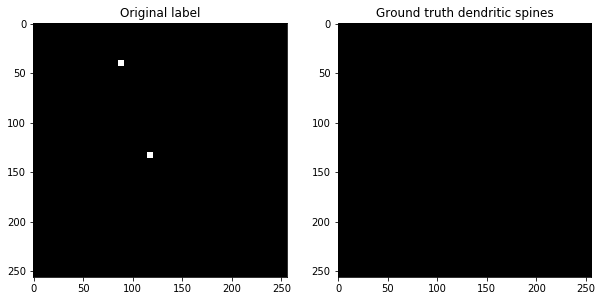

0.0
1.1920929e-07


In [0]:
img = y_test[0, :, :,0]
pred = y_pred[0 , :, :, 0]

plt.figure(figsize= (10, 20))
plt.subplot(121)
plt.imshow(img,cmap = 'gray')
plt.title('Original label')
plt.subplot(122)
imgplot2 = plt.imshow(pred, cmap='gray')
plt.title('Ground truth dendritic spines')
plt.show()

print(np.min(pred[:]))
print(np.max(pred[:]))

In [0]:
model.save('shape_prior_model.h5')